In [1]:
# 주요 라이브러리 import
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

In [3]:
# 데이터 로드
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [4]:
# 데이터 전처리 함수
def preprocess_data(df, freq_encoders=None, is_train=True):
    df = df.copy()
    df.dropna(axis=1, how='all', inplace=True)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    # 수치형 열 처리
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

    # 범주형 열 처리
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # 극단값 처리
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)

    # 정수형 열 처리
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df[col] = df[col].round().astype('int64')

    # 'Set ID' 열이 있다면 제거
    if 'Set ID' in df.columns:
        df = df.drop('Set ID', axis=1)
    
    df.dropna(axis=1, how='all', inplace=True)

    # 빈도 인코딩
    if is_train:
        freq_encoders = {}
        for col in categorical_cols:
            freq_encoders[col] = df[col].value_counts(normalize=True)
            df[col] = df[col].map(freq_encoders[col])
    else:
        for col in categorical_cols:
            df[col] = df[col].map(freq_encoders[col])
            df[col].fillna(0, inplace=True)  # 새로운 카테고리에 대해 0 할당

    return df, freq_encoders

def frequency_encode(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    return df[column].map(freq_encoding)

In [5]:
# 'target' 열을 별도로 저장
target = train_data['target']

In [6]:
# 'target' 열을 제외한 나머지 데이터 전처리
train_data_without_target = train_data.drop('target', axis=1)

In [7]:
# 데이터 전처리 적용
train_data_processed, freq_encoders = preprocess_data(train_data_without_target, is_train=True)

In [8]:
# 전처리된 데이터에 'target' 열 다시 추가
train_data_processed['target'] = target

In [9]:
# train_data_processed 확인
print("Train data demo shape:", train_data_processed.shape)
print("\nTrain data demo preview:")
print(train_data_processed.head())
print("\nTrain data demo info:")
train_data_processed.info()
train_data_processed

Train data demo shape: (40506, 186)

Train data demo preview:
   Wip Line_Dam  Process Desc._Dam  Equipment_Dam  Model.Suffix_Dam  \
0           1.0                1.0       0.617933          0.065052   
1           1.0                1.0       0.617933          0.065052   
2           1.0                1.0       0.382067          0.834938   
3           1.0                1.0       0.382067          0.834938   
4           1.0                1.0       0.617933          0.834938   

   Workorder_Dam  Insp. Seq No._Dam  Insp Judge Code_Dam  \
0       0.002493                1.0                  1.0   
1       0.001654                1.0                  1.0   
2       0.002592                1.0                  1.0   
3       0.002592                1.0                  1.0   
4       0.000790                1.0                  1.0   

   CURE END POSITION X Collect Result_Dam  \
0                                   240.0   
1                                   240.0   
2              

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1.0,1.0,0.617933,0.065052,0.002493,1.0,1.0,240.0,2.5,-90.0,...,50.0,91.8,270.0,50.0,114.612,19.9,7.0,127.0,1.0,Normal
1,1.0,1.0,0.617933,0.065052,0.001654,1.0,1.0,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.600,7.0,185.0,1.0,0.0,Normal
2,1.0,1.0,0.382067,0.834938,0.002592,1.0,1.0,1000.0,12.5,90.0,...,50.0,91.8,270.0,50.0,114.612,19.8,10.0,73.0,1.0,Normal
3,1.0,1.0,0.382067,0.834938,0.002592,1.0,1.0,1000.0,12.5,90.0,...,91.8,270.0,50.0,85.0,19.900,12.0,268.0,1.0,0.0,Normal
4,1.0,1.0,0.617933,0.834938,0.000790,1.0,1.0,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.700,8.0,121.0,1.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1.0,1.0,0.617933,0.834938,0.000765,1.0,1.0,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.200,1.0,289.5,1.0,0.0,Normal
40502,1.0,1.0,0.382067,0.834938,0.001605,1.0,1.0,1000.0,12.5,90.0,...,50.0,91.8,270.0,50.0,114.612,20.5,14.0,197.0,1.0,Normal
40503,1.0,1.0,0.617933,0.834938,0.001703,1.0,1.0,240.0,2.5,-90.0,...,50.0,91.8,270.0,50.0,85.000,19.7,1.0,27.0,1.0,Normal
40504,1.0,1.0,0.382067,0.834938,0.003555,1.0,1.0,1000.0,12.5,90.0,...,91.8,270.0,50.0,85.0,20.100,13.0,117.0,1.0,0.0,Normal


In [10]:
# 레이블 인코딩
le = LabelEncoder()
y = le.fit_transform(train_data_processed['target'])

In [11]:
# 특성 선택 (target 열 제외)
features = train_data_processed.drop('target', axis=1).columns
X = train_data_processed[features]

train_features = X.columns.tolist()

In [12]:
# 전체 데이터셋에 대한 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# PCA 객체 생성 (모든 주성분 유지)
pca_full = PCA(n_components=min(X_scaled.shape), random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

PCA(n_components=185, random_state=110)

In [14]:
# 누적 설명 분산 비율과 Eigenvalue 계산
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
eigenvalues = pca_full.explained_variance_

Text(0.5, 1.0, 'Scree Plot with Cumulative Variance Ratio and Eigenvalues')

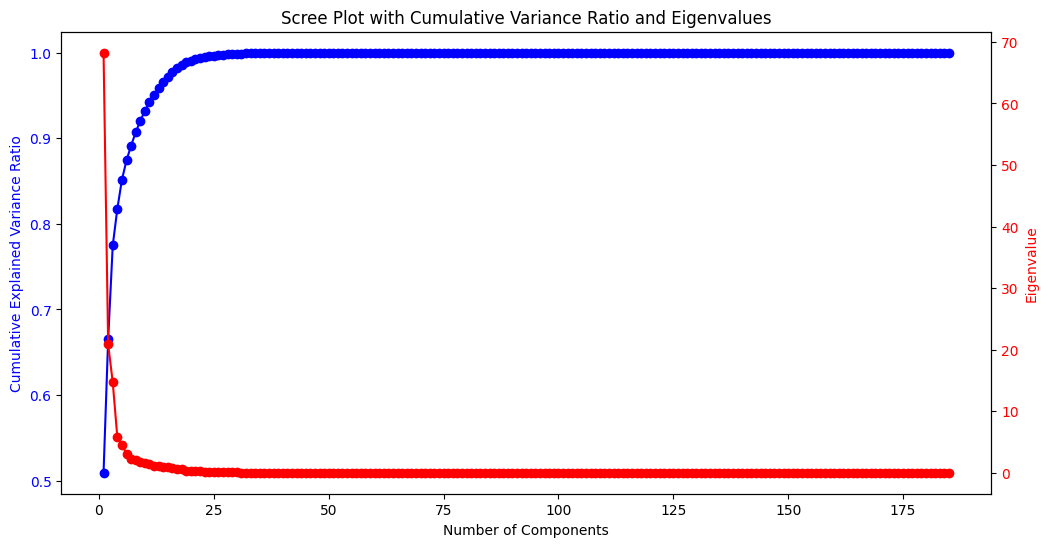

In [15]:
# Scree plot 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 누적 설명 분산 비율 플롯 (왼쪽 y축)
ax1.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Eigenvalue 플롯 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ro-')
ax2.set_ylabel('Eigenvalue', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Scree Plot with Cumulative Variance Ratio and Eigenvalues')

In [16]:
# 99% 설명 분산에 해당하는 주성분 개수 찾기
n_components_95 = next(i for i, ratio in enumerate(cumulative_variance_ratio) if ratio >= 0.99) + 1
ax1.axhline(y=0.85, color='g', linestyle='--')
ax1.axvline(x=n_components_95, color='g', linestyle='--')
ax1.text(n_components_95, 0.5, f'90% variance at {n_components_95} components', color='g')

Text(20, 0.5, '90% variance at 20 components')

In [17]:
# Kaiser criterion (Eigenvalue > 1) 표시
kaiser_components = sum(eigenvalues > 1)
ax2.axhline(y=1, color='purple', linestyle='--')
ax2.text(kaiser_components + 1, 1.5, f'Kaiser criterion\nat {kaiser_components} components', color='purple')

plt.show()

print(f"Number of components for 80% explained variance: {n_components_95}")
print(f"Number of components with Eigenvalue > 1 (Kaiser criterion): {kaiser_components}")

Number of components for 80% explained variance: 20
Number of components with Eigenvalue > 1 (Kaiser criterion): 13


In [18]:
# 선택된 주성분 개수로 PCA 수행
pca = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after PCA: {X_pca.shape[1]}")

Original number of features: 185
Number of features after PCA: 20


In [19]:
# PCA가 적용된 데이터를 훈련셋과 검증셋으로 나누기
X_train_pca, X_val_pca, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

In [20]:
# 훈련셋에 대해 SMOTE 적용
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("After SMOTE:")
print(f"Train set - Normal: {sum(y_train_resampled == 0)}, AbNormal: {sum(y_train_resampled == 1)}")

After SMOTE:
Train set - Normal: 26709, AbNormal: 26709


In [21]:
# 각 모델의 하이퍼파라미터 탐색 공간 정의
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

knn_params = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

lg_params = {
    'C': [0.1, 1.0],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000]
}

f1_scorer = make_scorer(f1_score, pos_label='AbNormal')

In [22]:
# RandomizedSearchCV를 이용한 모델 최적화
def optimize_model(model, params, X, y):
    random_search = RandomizedSearchCV(
        model, 
        params, 
        n_iter=10,  # 반복 횟수 감소
        cv=3,       # 교차 검증 폴드 수 감소
        n_jobs=-1,
        scoring='neg_log_loss',
        random_state=RANDOM_STATE,
        error_score='raise'
    )
    random_search.fit(X, y)
    return random_search.best_estimator_

In [23]:
# 각 모델 정의
rf = RandomForestClassifier(random_state=RANDOM_STATE)
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
lg = LogisticRegression(random_state=RANDOM_STATE)

In [24]:
# 각 모델 최적화
rf_optimized = optimize_model(rf, rf_params, X_train_resampled, y_train_resampled)

In [25]:
knn_optimized = optimize_model(knn, knn_params, X_train_resampled, y_train_resampled)

In [26]:
gb_optimized = optimize_model(gb, gb_params, X_train_resampled, y_train_resampled)

In [27]:
lg_optimized = optimize_model(lg, lg_params, X_train_resampled, y_train_resampled)

c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [28]:
# Voting 앙상블 모델 구축
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_optimized),
        ('knn', knn_optimized),
        ('gb', gb_optimized),
        ('lg', lg_optimized)
    ],
    voting='soft', n_jobs=-1
)

In [29]:
# 앙상블 모델 학습
voting_model.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     random_state=110)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=20,
                                                   weights='distance')),
                             ('gb',
                              GradientBoostingClassifier(max_depth=5,
                                                         min_samples_split=5,
                                                         random_state=110)),
                             ('lg',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=110,
                                                 solver='liblinear'))],
                 n_jobs=-1, voting='soft')

In [30]:
# 검증 세트에 대한 예측
y_val_pred_ensemble = voting_model.predict(X_val_pca)

In [31]:
# 모델 성능 평가
abnormal_label_index = list(le.classes_).index('AbNormal')
f1 = f1_score(y_val, y_val_pred_ensemble, pos_label=abnormal_label_index)
print("Model Validation F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_ensemble, target_names=le.classes_))

Model Validation F1 Score: 0.1781021897810219

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.12      0.35      0.18       705
      Normal       0.95      0.84      0.90     11447

    accuracy                           0.81     12152
   macro avg       0.54      0.59      0.54     12152
weighted avg       0.91      0.81      0.85     12152



In [32]:
# f1-Score: 0.17248603351955308 (Validation Set)

In [33]:
# 테스트 데이터 전처리
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
set_id = test_data['Set ID']  # Set ID 열 저장
test_data_without_set_id = test_data.drop('Set ID', axis=1)  # Set ID 열 제거
test_data_processed, _ = preprocess_data(test_data_without_set_id, freq_encoders, is_train=False)

C:\Users\99kih\AppData\Local\Temp\ipykernel_37420\4252892884.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)  # 새로운 카테고리에 대해 0 할당
C:\Users\99kih\AppData\Local\Temp\ipykernel_37420\4252892884.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [34]:
# 훈련 데이터의 특성과 테스트 데이터의 특성을 일치시킵니다.
common_features = list(set(train_features) & set(test_data_processed.columns))
test_X = test_data_processed[common_features]

In [35]:
# 훈련 데이터와 동일한 특성 순서로 재정렬
test_X = test_X.reindex(columns=train_features)

In [36]:
# 테스트 데이터에 대해 스케일링과 PCA를 적용합니다
test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

In [37]:
# Set ID 열 다시 추가
test_data_processed['Set ID'] = set_id

In [38]:
# 예측
test_pred = voting_model.predict(test_X_pca)
test_pred_labels = le.inverse_transform(test_pred)

In [39]:
# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred_labels

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [40]:
# 예측 결과 확인
print("\n예측된 레이블 분포:")
print(pd.Series(test_pred_labels).value_counts())


예측된 레이블 분포:
Normal      14387
AbNormal     2974
Name: count, dtype: int64


In [41]:
# test set f1-score: 0.176260 